In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [6]:
!kaggle datasets download -d arjuntejaswi/plant-village

 99% 324M/329M [00:10<00:00, 38.4MB/s]
100% 329M/329M [00:10<00:00, 32.9MB/s]


In [7]:
import zipfile
zip=zipfile.ZipFile('/content/plant-village.zip')
zip.extractall('/content')
zip.close()

In [8]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [9]:
Batch_Size=32
image_size=256
df=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=Batch_Size,
)

Found 20638 files belonging to 15 classes.


In [11]:
class_names=df.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [12]:
for image_class,class_labels in df.take(1):
  print(image_class.shape)
  print(class_labels.numpy())

(32, 256, 256, 3)
[ 9  5  8  5  0  3  7 10  1  6 10  9 11 12  5  7 10  9  2  7  5 12 13  2
  2  1  5 13  2  7  9  0]


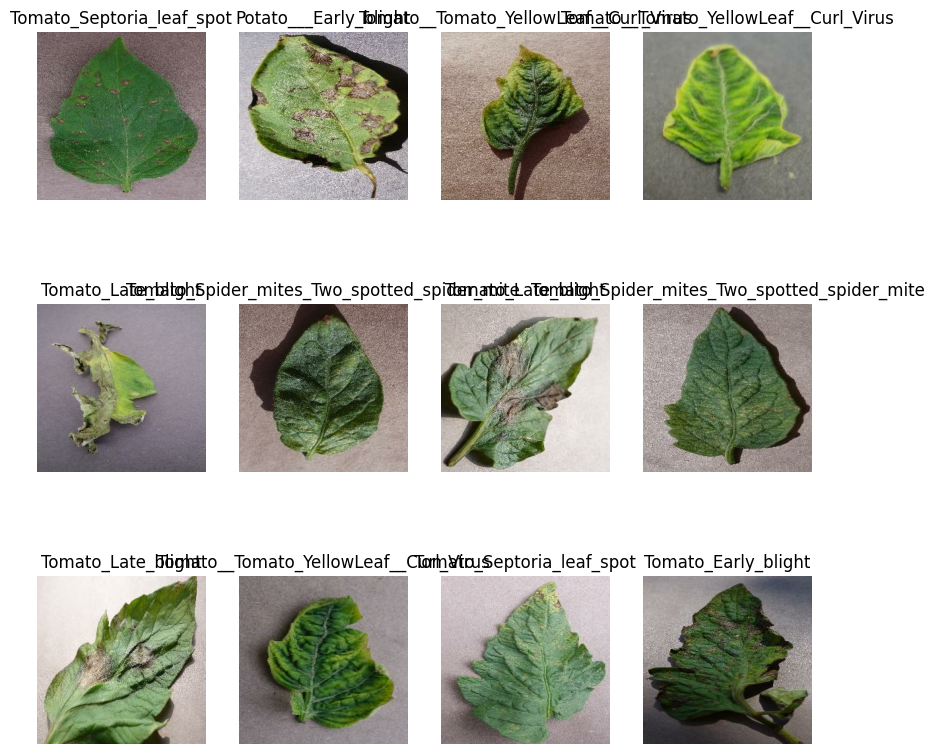

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
train_size=int(0.8*len(df))
train_ds=df.take(train_size)
vali_size=int(0.1*len(df))
test_size=int(0.1*len(df))
test_ds=df.skip(train_size)
vali_ds=test_ds.take(vali_size)
test_ds=test_ds.skip(vali_size)

In [15]:
augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resizing=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
input_shape=(Batch_Size,image_size,image_size,3)
model = models.Sequential([
    resizing,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax'),
])


model.build(input_shape)

In [19]:
model.compile(
    optimizer='adam',
    loss='SparseCategoricalCrossentropy',
    metrics=['accuracy']
)

In [21]:
history=model.fit(train_ds,
                  batch_size=Batch_Size,
                  validation_data=vali_ds,
                  verbose=1,
                  epochs=40,)

Epoch 1/40
516/516 [==============================] - 203s 393ms/step - loss: 1.8988 - accuracy: 0.3707 - val_loss: 1.5446 - val_accuracy: 0.5005
Epoch 2/40
516/516 [==============================] - 198s 383ms/step - loss: 1.0461 - accuracy: 0.6429 - val_loss: 0.8501 - val_accuracy: 0.7065
Epoch 3/40
516/516 [==============================] - 217s 420ms/step - loss: 0.7610 - accuracy: 0.7364 - val_loss: 0.6787 - val_accuracy: 0.7676
Epoch 4/40
516/516 [==============================] - 198s 384ms/step - loss: 0.5947 - accuracy: 0.7921 - val_loss: 0.5500 - val_accuracy: 0.8120
Epoch 5/40
516/516 [==============================] - 195s 378ms/step - loss: 0.5110 - accuracy: 0.8207 - val_loss: 0.7072 - val_accuracy: 0.7710
Epoch 6/40
516/516 [==============================] - 205s 397ms/step - loss: 0.4388 - accuracy: 0.8445 - val_loss: 0.5469 - val_accuracy: 0.8125
Epoch 7/40
516/516 [==============================] - 198s 383ms/step - loss: 0.3942 - accuracy: 0.8616 - val_loss: 0.3923 -

In [24]:
model.evaluate(test_ds)

65/65 [==============================] - 19s 35ms/step - loss: 0.2133 - accuracy: 0.9321


[0.21325252950191498, 0.9321463108062744]

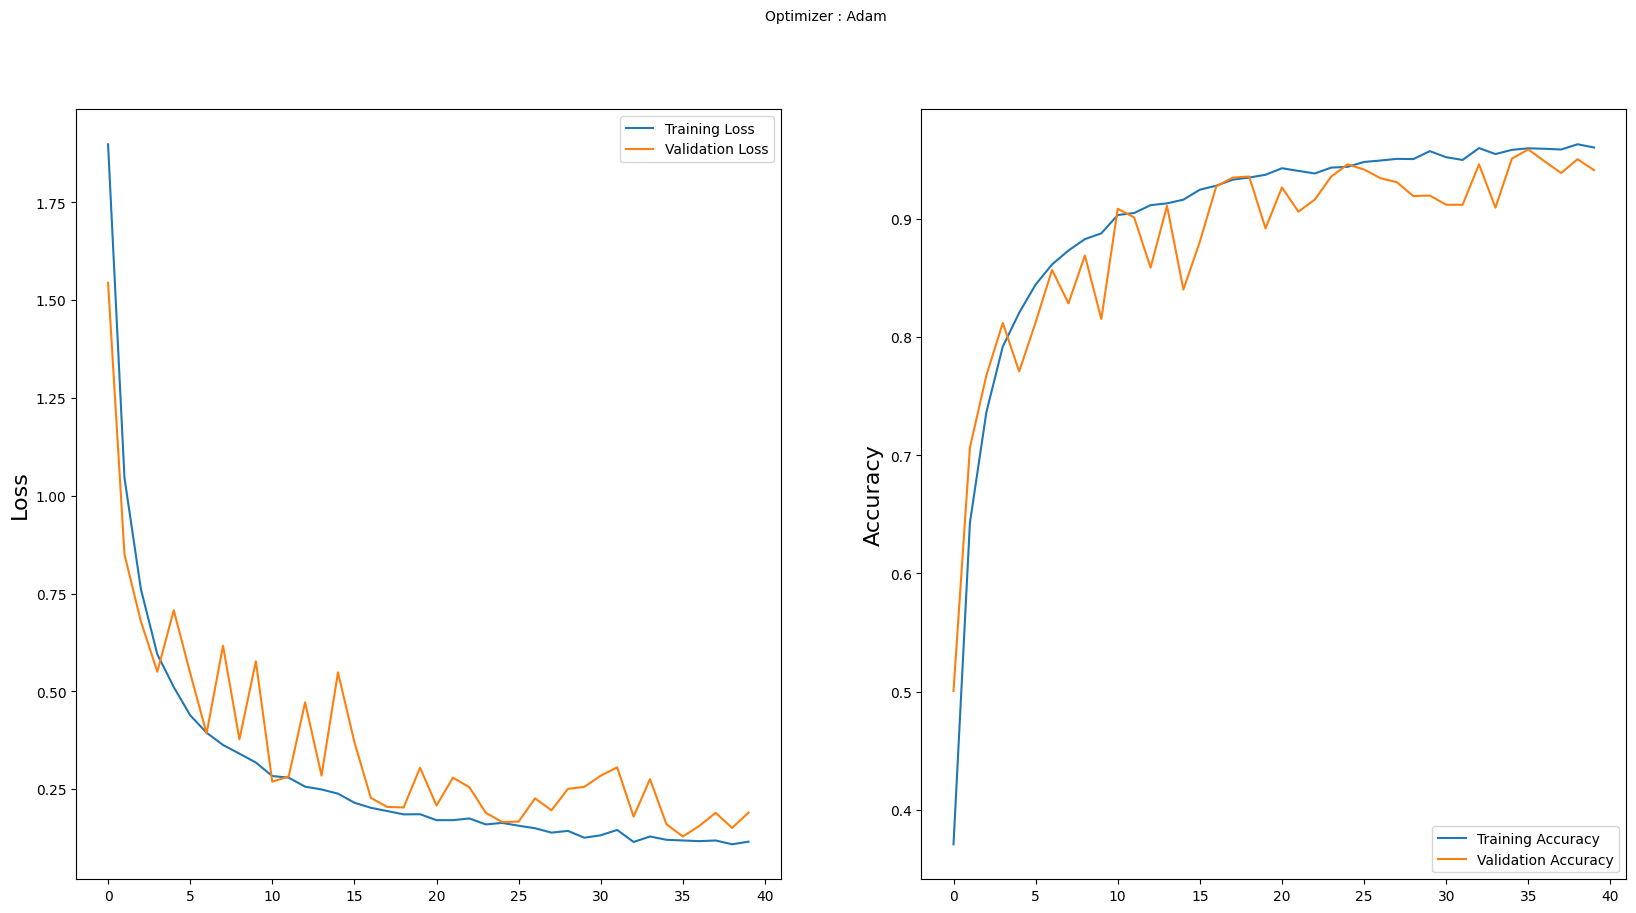

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [36]:
import cv2
img1=cv2.imread('/content/PlantVillage/Potato___healthy/07dfb451-4378-49d1-b699-33a5fc49ff07___RS_HL 5399.JPG')
img1.shape

(256, 256, 3)

In [37]:
import numpy as np
img1=np.expand_dims(img1,axis=0)
predicted=model.predict(img1)

1/1 [==============================] - 0s 25ms/step


In [38]:
predicted

array([[2.2975782e-05, 9.9990416e-01, 1.1414668e-06, 2.6586786e-06,
        4.7464178e-05, 2.2900604e-08, 9.8815099e-07, 1.8516944e-07,
        7.5865055e-14, 8.3385459e-08, 9.2509342e-09, 2.0324494e-05,
        4.6804347e-09, 5.4100700e-12, 1.1221420e-08]], dtype=float32)

In [39]:
from tensorflow.keras.models import load_model
from google.colab import files
model.save('plant_disease_model8.h5')